### Validation with snRNAseq

Step4 -- validate sn seq hepatocytes with seqscope hepatocytes

In [ ]:
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
from scipy.stats import beta
# from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

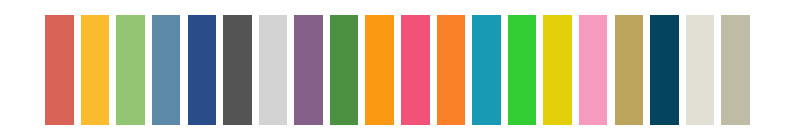

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load data

In [3]:
# load processed sn rna seq data
path = '../validation6_snRNAseq/seqscope/output/sn.pkl'
pickle_dict = pd.read_pickle(path)
sn_counts = pickle_dict['counts']
sn_norm_counts = pickle_dict['norm_counts']
sn_genes = pickle_dict['genes']
sn_cells = pickle_dict['cells']

In [24]:
# load ella seqscope results
fn = '../ella/output_ella/ella_seqscope.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
cells_dict = res_dict['cells_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

In [25]:
# load seqsope gene expr
path='../ella/__input/seqscope_data_dict.pkl'
pickle_dict = pd.read_pickle(path)
data_df = pickle_dict['data_df']
del pickle_dict

#### genes to validate

In [28]:
validate_genes_dict = {}
for t in types_list:
    validate_genes_dict[t] = list(set(sn_genes).intersection(genes_dict[t]))
    print(f'#genes to validate {t} {len(validate_genes_dict[t])}')

#genes to validate H1 1233
#genes to validate H2 1259
#genes to validate TD1 466
#genes to validate TD2 1276


#### compute sn/sc ratio for `validate_gene_dict`

In [33]:
# compute ratios
ratio_dict = {}
for t in tqdm(types_list, desc='Processing'):
    genes_t = validate_genes_dict[t]
    ratio_t = np.zeros(len(genes_t))
    for ig, g in enumerate(genes_t):
        # avg gene count per cell in sc data
        ig_sn = np.where(sn_genes == g)[0][0]
        sn_avg = np.mean(sn_counts[:,ig_sn])
        # avg gene count per cell in seqscope
        nc = len(cells_dict[t])
        f1 = data_df.cell.isin(cells_dict[t])
        f2 = data_df.gene==g
        df_g = data_df[f1&f2]
        umi_sum = df_g.umi.sum()
        avg = umi_sum/nc
        # sn/sc ratio
        ratio_g = sn_avg/avg
        ratio_t[ig] = ratio_g
    ratio_dict[t]= ratio_t
# 20min

# save
# path = 'output/snRNAseq_ratio_dict'
# with open(path, 'wb') as f:
#     pickle.dump(ratio_dict, f)

# load
# path = 'output/snRNAseq_ratio_dict'
# ratio_dict = pd.read_pickle(path)

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [16:43<00:00, 250.97s/it]


In [34]:
# find genes and their ratio, label, score 
ratio_df_dict = {}
for t in types_list:
    pv_t = p_fdr_dict[t]
    label_t = label_dict[t]
    score_t = score_dict[t]
    
    genes_t = np.array(genes_dict[t])
    genes2_t = list(set(genes_t).intersection(validate_genes_dict[t]))

    ratio2_t = np.zeros(len(genes2_t))
    score2_t = np.zeros(len(genes2_t))
    label2_t = np.zeros(len(genes2_t))
    
    for ig, g in enumerate(genes2_t):
        ig_ratio = np.where(np.array(validate_genes_dict[t]) == g)[0][0]
        ratio_g = ratio_dict[t][ig_ratio]
        ratio2_t[ig] = ratio_g
        ig_score = np.where(np.array(genes_dict[t]) == g)[0][0]
        score_g = score_t[ig_score]
        label_g = label_t[ig_score]
        score2_t[ig] = score_g
        label2_t[ig] = label_g
    ratio_df_dict[t] = pd.DataFrame({'gene':genes2_t, 'ratio':ratio2_t, 'score':score2_t, 'label':label2_t})

#### all types merged together

In [35]:
# merge together
merged_df = pd.concat(ratio_df_dict.values(), ignore_index=True)
merged_df.head(3)

,gene,ratio,score,label
0,Phb2,3.253682,0.172374,-1.0
1,Dpyd,163.727049,0.071566,-1.0
2,H2-T23,7.435806,0.726818,-1.0


In [36]:
# wilcoxon cluster 1 vs 2-5 
sample1 = merged_df['ratio'][(merged_df.label==0)].values
sample2 = merged_df['ratio'][(merged_df.label==1)|(merged_df.label==2)|(merged_df.label==3)|(merged_df.label==4)].values
__statistic, p_value1 = mannwhitneyu(sample1, sample2)
print(f'1 vs 2-5 \np={p_value1}')
print(f'fc={np.mean(sample1)/np.mean(sample2)}')
p12 = [p_value1]

# wilcoxon cluster 1 vs all else
sample3 = merged_df['ratio'][(merged_df.label==-1)|(merged_df.label==1)|(merged_df.label==2)|(merged_df.label==3)|(merged_df.label==4)].values
__statistic, p_value2 = mannwhitneyu(sample1, sample3)
print(f'1 vs others \np={p_value2}')
print(f'fc={np.mean(sample1)/np.mean(sample3)}')
p13 = [p_value2]

1 vs 2-5 
p=4.8958179069689535e-22
fc=15.310602855819148
1 vs others 
p=1.3647231101264491e-11
fc=4.803891986479897


In [37]:
# bar plot
means = [
    (merged_df.ratio)[merged_df.label==0].mean(),
    (merged_df.ratio)[(merged_df.label!=0)&(merged_df.label!=-1)].mean(),
    (merged_df.ratio)[merged_df.label!=-1].mean(),
]

# Individual data points for each category
data_points = [
    (merged_df.ratio)[merged_df.label==0],
    (merged_df.ratio)[(merged_df.label!=0)&(merged_df.label!=-1)],
    (merged_df.ratio)[merged_df.label!=-1],
]

# remove outliers
lbs = []
ubs = []
data_points2 = []
for j in range(len(data_points)):
    data_j = data_points[j]
    
    # IQR
    Q1 = np.percentile(data_j, 25)
    Q3 = np.percentile(data_j, 75)
    # IQR = Q3 - Q1
    lower_bound = Q1
    upper_bound = Q3
    lbs.append(np.maximum(means[j]-lower_bound,0))
    ubs.append(np.maximum(upper_bound-means[j],0))
    
    data_j2 = data_j[(data_j >= lower_bound) & (data_j <= upper_bound)]
    
    data_points2.append(data_j2)

In [38]:
def sig_symb(p_value):
    if p_value <= 0.001:
        sig_symbol = '***'
    elif p_value <= 0.01:
        sig_symbol = '**'
    elif p_value <= 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    return sig_symbol

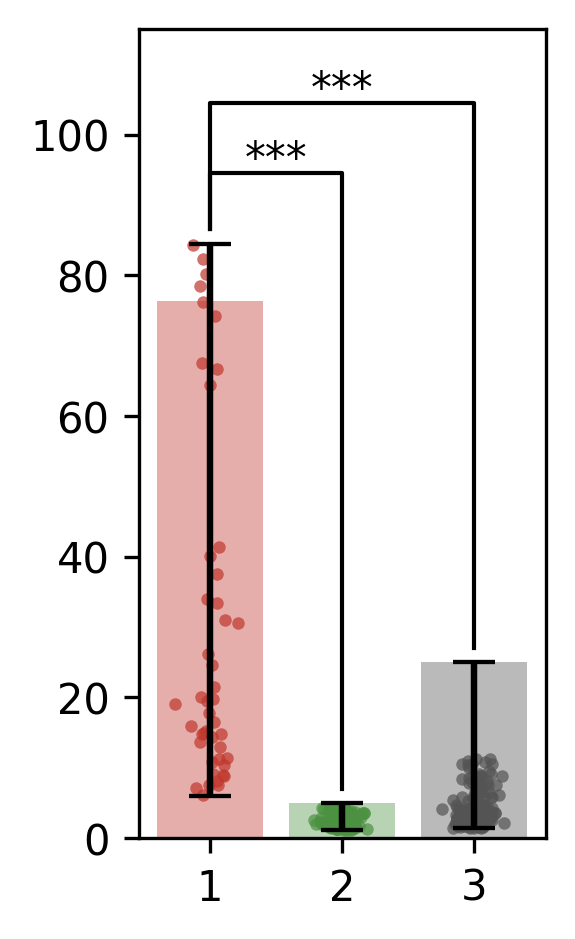

In [52]:
nr = 1
nc = 1
ss_nr = 3.5
ss_nc = 7/4
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

colors = [red, darkgreen, darkgray]
bar_pos = np.array([1,2,3])

# bar
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              color=colors,
              zorder=1,
              alpha=0.4)
# the std 
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              zorder=3,
              alpha=0)

# Define the width of the spread
width = bars[0].get_width() / 1.0

# Adding spread dots
for _i, (i, data) in enumerate(zip(bar_pos, data_points2)):
    # Spread dots around the center of the bar
    x = np.random.normal(i, width/10, size=len(data))
    ax.plot(x, data, '.', 
            color=colors[_i], 
            markeredgewidth=0, mec='none', alpha=0.7, zorder=1)

# add 1 vs 2-5 pv
hgap_big = 10
hgap_small = 2
for j, p in enumerate(p12[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+1
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+1]+ubs[j*3+1]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
# add 1 vs others pv
hgap_big = 10*2
hgap_small = 2
for j, p in enumerate(p13[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+2
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+2]+ubs[j*3+2]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_ylim((0, 115))

# plt.savefig(f'figs/fig_snRNAseq_all.pdf', dpi=300, bbox_inches='tight')